In [1]:
%load_ext autoreload
%autoreload 2

import torch as t
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration, Blip2Processor, Blip2ForConditionalGeneration, BlipForQuestionAnswering

In [2]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [3]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)

2024-02-25 00:12:21.059099: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 00:12:21.059125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 00:12:21.059810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 00:12:21.063608: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 00:12:21.564797: W tensorflow/compiler/tf2

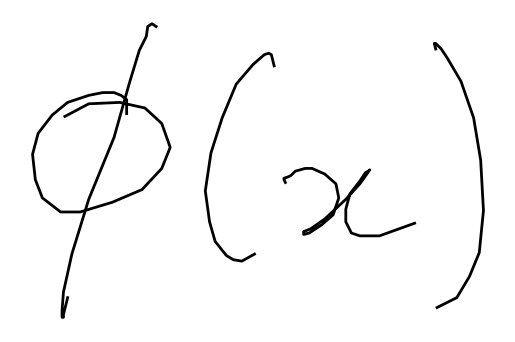

In [4]:
raw_image = Image.open("../img_data/inkML_data_CROHME_training_2011_formulaire001-equation001.inkml_0.png").convert('RGB')
raw_image

### Before finetuning:

In [5]:
text = "What does the formula above say?"
inputs = processor(raw_image,text, return_tensors="pt").to(device)
out = model.generate(**inputs, max_new_tokens = 50)
print(processor.decode(out[0], skip_special_tokens=True))                            

c


### Finetuning:

In [6]:
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sklearn as skl

def set_seed(seed):
    np.random.seed(seed)
    t.manual_seed(seed)
    if t.cuda.is_available():
        t.cuda.manual_seed_all(seed)
    skl.utils.check_random_state(seed)

class MathCaptionsDataset(Dataset):
    """
    A dataset object that loads in images from img_data and captions from labels.csv.

    - Processor: A Huggingface processor object that will be used to process the images and captions.
    - img_dir: The directory containing the images and labels.csv.
    - csv_file: The file containing the captions.
    - transform: A torchvision transform to be applied to the images.
    """
    def __init__(self, processor,
                 img_dir = "../img_data", 
                 csv_file = "labels.csv",
                 transform = None, use_float16 = False,
                 device = t.device("cuda" if t.cuda.is_available() else "cpu"),
                 prefix = "What does the formula above say?", partition = "train",
                 test_split = 0.2, random_seed = 0):
        
        self.img_dir = img_dir
        self.csv_path = os.path.join(img_dir, csv_file)
        self.labels = pd.read_csv(self.csv_path)
        # Randomly select data_split of the data for training and the rest for validation
        self.labels, self.labels_val = train_test_split(self.labels, test_size = test_split, random_state = random_seed)
        self.partition = partition
        self.transform = transform
        self.processor = processor
        self.use_float16 = use_float16
        self.device = device
        self.prefix = prefix

    def __len__(self):
        if self.partition == "train": return len(self.labels)
        else: return len(self.labels_val)
    
    def train(self):
        self.partition = "train"
    
    def val(self):
        self.partition = "val"

    def __getitem__(self, idx):
        if t.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 1])
        image = Image.open(img_name).convert('RGB')
        inputs = self.processor(image, self.prefix, padding = "max_length", return_tensors="pt").to(self.device)
        if self.use_float16:
            inputs = inputs.to(t.float16)
        for key in inputs:
            inputs[key] = inputs[key].squeeze() # Get rid of batch dimension since the dataloader will batch it for us.

        if self.partition == "train": caption = self.labels.iloc[idx, 0]
        else: caption = self.labels_val.iloc[idx, 0]
        caption = self.processor.tokenizer.encode(
            caption, return_tensors="pt", padding = "max_length", max_length = 256, # Tweak this
            ).to(self.device).squeeze()
        # caption = self.processor(text = caption, padding = "max_length", max_length = 128, # Tweak this
        #                          return_tensors="pt", 
        #                          ).to(self.device)["input_ids"].squeeze()

        return inputs, caption

In [8]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

# Hyperparams
NUM_EPOCHS = 5
LEARNING_RATE = 5e-5
BATCH_SIZE = 8 # 10 gigs of Vram -> 4, <5 gigs of vram -> 2
SHUFFLE_DATASET = True

set_seed(0)
optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_ds = MathCaptionsDataset(processor); train_ds.train()
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET, num_workers=0)
val_ds = MathCaptionsDataset(processor); val_ds.val()
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model.to(device)
model.train()

history = []; val_history = []; val_timesteps = []
ema_loss = None; ema_alpha = 0.99
scaler = t.cuda.amp.GradScaler(enabled = True)
for epoch in range(NUM_EPOCHS):
    with tqdm(train_dl, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}") as pbar:
        for batch, captions in pbar:
            pixel_values = batch["pixel_values"]
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            
            optimizer.zero_grad()
            with t.autocast(device_type = "cuda", dtype = t.float16, enabled = True):
                outputs = model(pixel_values = pixel_values,
                                attention_mask = attention_mask,
                                input_ids = input_ids,
                                labels = captions)
                loss = outputs.loss
                history.append(loss.item())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if ema_loss is None: ema_loss = loss.item()
            else: ema_loss = ema_loss * ema_alpha + loss.item() * (1 - ema_alpha)
            pbar.set_postfix(loss=ema_loss)
    
    model.eval()
    with t.no_grad():
        val_losses = []
        for batch, captions in tqdm(val_dl):
            pixel_values = batch["pixel_values"]
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            outputs = model(pixel_values = pixel_values,
                            attention_mask = attention_mask,
                            input_ids = input_ids,
                            labels = captions)
            val_losses.append(outputs.loss.item())
        print(f"Validation loss: {np.mean(val_losses)}")
        val_history.append(np.mean(val_losses))
        val_timesteps.append(len(history) - 1)

Epoch 1/5:   0%|          | 0/1110 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
100%|██████████| 278/278 [01:17<00:00,  3.58it/s]


Validation loss: 0.10375806115728488


100%|██████████| 278/278 [01:18<00:00,  3.53it/s]


Validation loss: 0.0873701281363158


100%|██████████| 278/278 [01:18<00:00,  3.53it/s]


Validation loss: 0.09813527963894735


100%|██████████| 278/278 [01:19<00:00,  3.50it/s]


Validation loss: 0.12757316897723744


100%|██████████| 278/278 [01:18<00:00,  3.52it/s]

Validation loss: 0.14916444012372615


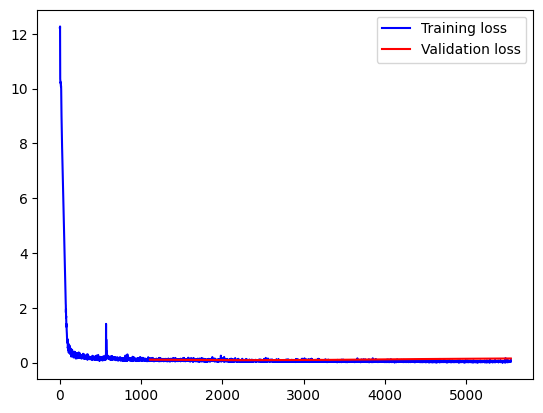

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data = history, color = "blue", label = "Training loss")
sns.lineplot(x = val_timesteps, y = val_history, color = "red", label = "Validation loss")
plt.legend()
plt.show()

### Validation Examples

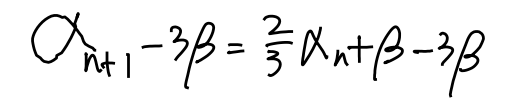

In [15]:
import random
# Randomly select a validation image and caption
idx = random.randint(0, len(val_ds.labels_val))
img_name = os.path.join(val_ds.img_dir, val_ds.labels_val.iloc[idx, 1])
image = Image.open(img_name).convert('RGB')
caption = val_ds.labels_val.iloc[idx, 0]
image

In [34]:
from IPython.display import display, Math, Latex

text = "What does the formula above say?"
inputs = processor(image,text, return_tensors="pt").to(device)
out = model.generate(**inputs, max_new_tokens = 50)
print("Prediction:")
display(Math(processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")))
print("Gt:")
display(Math(caption))

Prediction:


<IPython.core.display.Math object>

Gt:


<IPython.core.display.Math object>